# ArangoDB NetworkX Adapter Getting Started Guide  

<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/master/examples/ArangoDB_NetworkxAdapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![networkX](assets/logos/networkx_logo.svg) 
![arangodb](assets/logos/ArangoDB_logo.png) 

In this Notebook we learn how to export Graphs from [ArangoDB](https://www.arangodb.com/), a multi-model Graph Database into [NetworkX](https://networkx.github.io/), the swiss army knife for graph analysis ion python.

# Setup

In [ ]:
%%capture
!git clone https://github.com/arangoml/networkx-adapter.git
!rsync -av networkx-adapter/examples/ ./ --exclude=.git
!pip3 install networkx
!pip3 install matplotlib
!pip3 install adbnx_adapter==0.0.0.2.1
!pip3 install pyarango
!pip3 install python-arango

In [2]:
import json
import oasis
import networkx as nx
import matplotlib.pyplot as plt


from pyArango.connection import *
from adbnx_adapter.arangoDB_networkx_adapter import ArangoDB_Networkx_Adapter

# Create a Temporary ArangoDB Instance

In [3]:
# Request temporary instance from the managed ArangoDB Cloud Oasis.
con = oasis.getTempCredentials()

# Connect the driver to the temp database
conn = oasis.connect_pyarango(con)
db = conn[con["dbName"]]

print()
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])

Credentials expired.
Requesting new temp credentials.
Temp database ready to use.

https://5904e8d8a65f.arangodb.cloud:8529
Username: TUTts9nv3bma3kl0imcj2dhy
Password: TUTboqlf7w67jraqwi96ey9h5
Database: TUTak86sw3ds7owgacbed5kzg


Feel free to use to above URL to checkout the UI!

# Data Import

We will use an Fraud Detection example graph, explained in more detail in this [interactive notebook](https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Fraud_Detection.ipynb).

*Note the included arangorestore will only work on Linux system, if you want to run this notebook on a different OS please consider using the appropriate arangorestore from the [Download area](https://www.arangodb.com/download-major/).*

In [4]:
!./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --default-replication-factor 3  --input-directory "data/fraud_dump"

2020-05-12T08:25:57Z [5004] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://5904e8d8a65f.arangodb.cloud:8529'
2020-05-12T08:25:59Z [5004] INFO [abeb4] {restore} Database name in source dump is 'fraud-detection'
2020-05-12T08:25:59Z [5004] INFO [9b414] {restore} # Re-creating document collection 'account'...
2020-05-12T08:26:01Z [5004] INFO [9b414] {restore} # Re-creating document collection 'bank'...
2020-05-12T08:26:02Z [5004] INFO [9b414] {restore} # Re-creating document collection 'branch'...
2020-05-12T08:26:04Z [5004] INFO [9b414] {restore} # Re-creating document collection 'Class'...
2020-05-12T08:26:07Z [5004] INFO [9b414] {restore} # Re-creating document collection 'customer'...
2020-05-12T08:26:10Z [5004] INFO [9b414] {restore} # Re-creating edge collection 'accountHolder'...
2020-05-12T08:26:12Z [5004] INFO [9b414] {restore} # Re-creating edge collection 'Relationship'...
2020-05-12T08:26:14Z [5004] INFO [9b414] {restore} # Re-creating edge collection 'transaction'..

# Create Graph

The graph we will be using in the following looks as follows:

![networkX](assets/fraud_graph.jpeg) 

In [5]:
from pyArango.collection import Collection, Edges, Field
from pyArango.graph import Graph, EdgeDefinition


class account(Collection):
    _fields = {
        "Name": Field()
    }
    
class customer(Collection):
    _fields = {
        "Name": Field()
    }
    
class transaction(Edges): 
    _fields = {
    }

class accountHolder(Edges): 
    _fields = {
    }

class FraudDetection(Graph) :
    _edgeDefinitions = [EdgeDefinition("accountHolder", fromCollections=["customer"], toCollections=["account"]),EdgeDefinition("transaction", fromCollections=["account"], toCollections=["account"])]
    _orphanedCollections = []

fraudGraph = db.createGraph("FraudDetection")

print("Collection/Graph Setup done.")

Collection/Graph Setup done.


Feel free to visit the ArangoDB UI using the above link and login data and check the Graph!

# Connect ArangoDB and NetworkX 

We first connect the ArangoDB_Networkx_Adapter to our temp ArangoDB cluster:

In [6]:
ma = ArangoDB_Networkx_Adapter(conn = con)

Next, we need to define the attributes in the vertex and edge collections to be included:

*Note, we are currently working on making this step optional in the future!*

In [7]:
fraud_detection_attributes = { 'vertexCollections': 
                                  {'account': {'Balance', 'account_type', 'customer_id', 'rank'},\
                                   'bank': {'Country', 'Id', 'bank_id', 'bank_name'},\
                                   'branch':{'City', 'Country', 'Id', 'bank_id', 'branch_id', 'branch_name'},\
                                    'Class':{'concrete', 'label', 'name'},\
                                    'customer': {'Name', 'Sex', 'Ssn', 'rank'}},\
                               'edgeCollections' : 
                                  {'accountHolder': {'_from', '_to'},\
                                   'Relationship': {'_from', '_to', 'label', 'name', 'relationshipType'},\
                                    'transaction': {'_from', '_to'}}}

Now, we can export the networkX graph:

In [8]:
g = ma.create_networkx_graph(graph_name = 'FraudDetection',  graph_attributes = fraud_detection_attributes)

From here on we can simply use all networkX functionality:

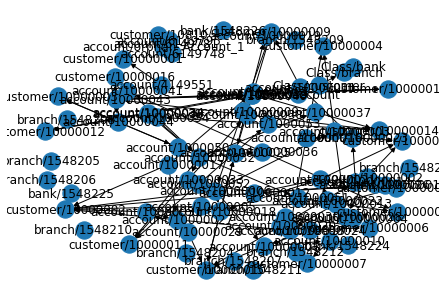

In [9]:
nx.draw(g, with_labels=True)

In [10]:
g.nodes()

NodeView(('account/6149748', 'account/10000041', 'account/10000043', 'account/6149781', 'account/10000036', 'account/10000040', 'account/10000042', 'account/10000001', 'account/10000035', 'account/10000027', 'account/10000044', 'account/10000008', 'account/1000054', 'account/4149551', 'account/10000034', 'account/10000015', 'account/1000053', 'account/10000014', 'account/1000050', 'account/10000003', 'account/10000022', 'account/10000017', 'account/6149795', 'account/10000030', 'account/10000020', 'account/10000013', 'account/10000039', 'account/10000029', 'account/10000019', 'account/10000028', 'account/10000037', 'account/10000012', 'account/10000024', 'account/orphan_Account_1', 'account/10000006', 'account/10000033', 'account/10000031', 'account/1000052', 'account/10000026', 'account/10000011', 'account/10000018', 'account/10000010', 'account/10000016', 'account/10000002', 'account/10000004', 'account/10000009', 'account/10000025', 'account/10000038', 'account/10000032', 'account/1

In [11]:
g.edges()

OutEdgeView([('account/6149748', 'customer/10810'), ('account/10000041', 'customer/10000016'), ('account/10000041', 'account/10000043'), ('account/10000043', 'customer/10000016'), ('account/10000043', 'account/10000044'), ('account/6149781', 'customer/10810'), ('account/10000036', 'customer/10000013'), ('account/10000036', 'account/10000041'), ('account/10000040', 'customer/10000015'), ('account/10000040', 'account/10000043'), ('account/10000042', 'customer/10000015'), ('account/10000042', 'account/10000043'), ('account/10000001', 'customer/10000008'), ('account/10000035', 'customer/10000012'), ('account/10000035', 'account/10000040'), ('account/10000027', 'customer/10000002'), ('account/10000027', 'account/10000015'), ('account/10000044', 'customer/10000003'), ('account/10000044', 'account/1000050'), ('account/10000008', 'customer/10000010'), ('account/10000008', 'account/10000010'), ('account/1000054', 'customer/10000016'), ('account/1000054', 'account/10000032'), ('account/4149551',

# Next Steps

* Explore [Interactive NetworkX Notebook](https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/NetworkX.ipynb)
* Explore [ArangoDB](https://www.arangodb.com/)
* Explore [Interactive ArangoDB tutorials](https://github.com/joerg84/ArangoDBUniversity#arangodb-university)